In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from collections import Counter

import scipy
from umap import UMAP
from sklearn.decomposition import PCA

In [2]:
''' defining functions used later within the notebook '''

def str_to_percent(word):
    str_num = re.findall("\d+\.\d+", word)
    if not str_num:
        str_num = re.findall("\d+", word)
    return float(str_num[0]) / 100

def map_hours(df):
    hour_map = {'Not at all': 0, 'Less than 1 hour': 1, '1-2 hours': 2, '3 or more hours': 3}
    df = df.applymap(lambda x: hour_map.get(x) if x in hour_map else x)
    return df

def calc_s(x,y):
    c = Counter(zip(x,y))
    s = [c[(xx,yy)] for xx,yy in zip(x,y)]
    return s

# Stolen from Isabella
def fill_nan_encode_categories(dataframe):
    # replace nan with -1 -> to keep them recognisable
    result = dataframe.fillna(-1)
    # make all columns a category -> even the numerical ones as they are not continuous numbers
    result = result.astype('category')
    # use pd's codes to make them numeric -> -1 disappears this way
    return result.apply(lambda x: x.cat.codes)

In [3]:
raw_df = pd.read_csv("../data/maps-synthetic-data-v1.1.csv")
raw_df.head()

,Unnamed: 0,X,flag,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
0,1,1,synthetic,NaN,3.0,30,59.294132,181.602831,107.0,NaN,...,0.0,Yes,Yes,often,No,"Yes, Some Days",Other,"Yes, Every Day",Female,A
1,2,2,synthetic,NaN,9.0,26,NaN,NaN,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,B
2,3,3,synthetic,NaN,3.0,24,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Yes, Some Days","Yes, Every Day",Other,Male,A
3,4,4,synthetic,No,NaN,22,49.812426,160.224186,NaN,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Male,A
4,5,5,synthetic,No,8.0,31,62.270030,191.703227,132.0,Yes,...,NaN,NaN,NaN,often,No,"Yes, Some Days","Yes, Every Day","Yes, Every Day",Female,A


Looking into negative correlation from dep_score and others

Dep_score = Child's depression score on CIS-R at 17.5 years old.

Columns thought to be negatively correlated:

musi_week = Average time child spent per day playing musical instruments on a typical weekday

musi_wend = Average time child spent per day playing musical instruments on a typical weekend day

read_week = Average time child spent per day reading books for pleasure on a typical weekday

read_wend = Average time child spent per day reading books for pleasure on a typical weekend day

out_sum_week = Average time child spent per day out of doors in summer on a typical weekday

out_sum_wend = Average time child spent per day out of doors in summer on a typical weekend day

out_win_week = Average time child spent per day out of doors in winter on a typical weekday

out_win_wend = Average time child spent per day out of doors in winter on a typical weekend day

In [4]:
columns = ['has_dep_diag','dep_score','dep_thoughts','secd_diag', 
           'musi_week', 'musi_wend', 'read_week', 'read_wend', 'out_sum_week','out_sum_wend', 'out_win_week', 'out_win_wend']

In [5]:
df = raw_df[columns]
df.shape

(13734, 12)

In [6]:
# Shamelessly stolen from Isabella
# replace nan with -1 -> to keep them recognisable
df = fill_nan_encode_categories(df)
df.columns

Index(['has_dep_diag', 'dep_score', 'dep_thoughts', 'secd_diag', 'musi_week',
       'musi_wend', 'read_week', 'read_wend', 'out_sum_week', 'out_sum_wend',
       'out_win_week', 'out_win_wend'],
      dtype='object')

<AxesSubplot:xlabel='out_win_wend', ylabel='dep_score'>

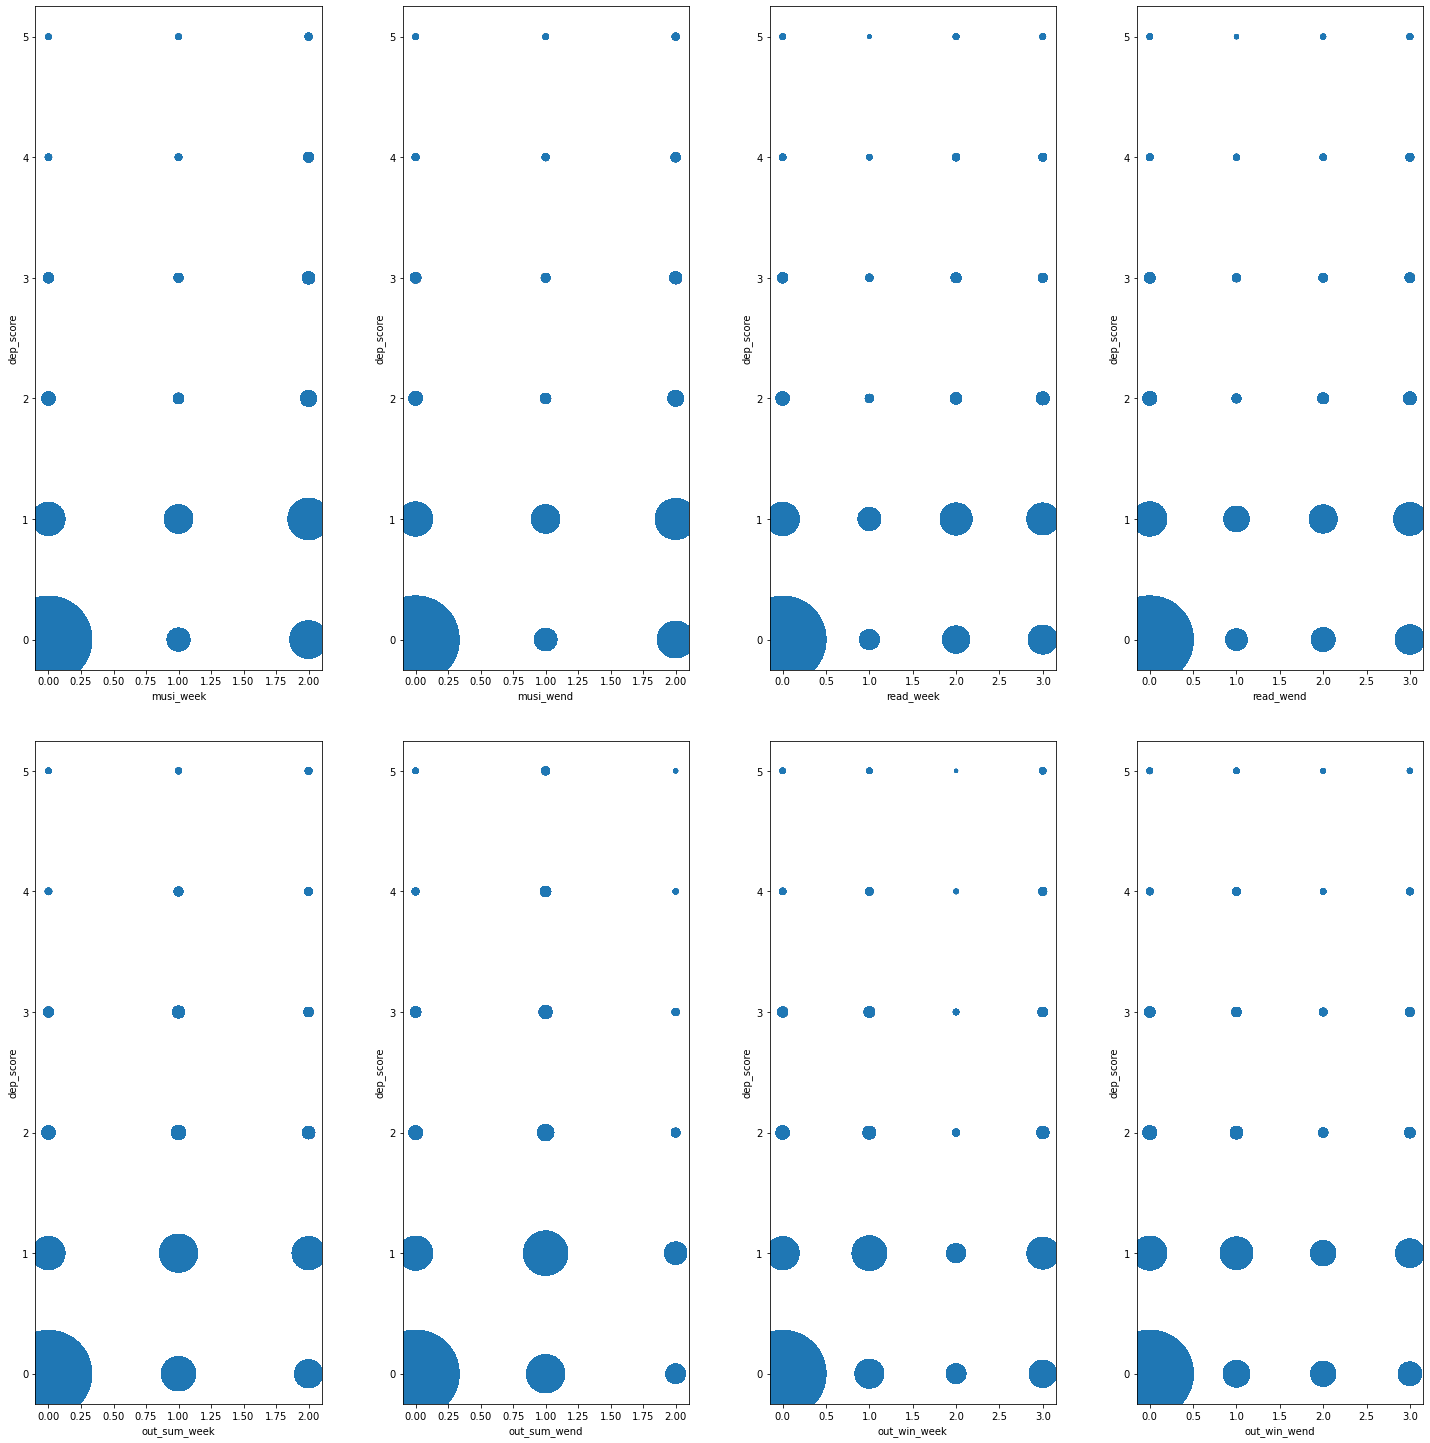

In [7]:
x = df['dep_score']

plt.rcParams["figure.figsize"] = [20, 20]

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.tight_layout(h_pad=5, w_pad=5)

y = df['musi_week']
df.plot(kind='scatter', x='musi_week',y='dep_score',s=calc_s(x,y), ax=axes[0,0])
y = df['musi_wend']
df.plot(kind='scatter', x='musi_wend',y='dep_score',s=calc_s(x,y), ax=axes[0,1])
y = df['read_week']
df.plot(kind='scatter', x='read_week',y='dep_score',s=calc_s(x,y), ax=axes[0,2])
y = df['read_wend']
df.plot(kind='scatter', x='read_wend',y='dep_score',s=calc_s(x,y), ax=axes[0,3])
y = df['out_sum_week']
df.plot(kind='scatter', x='out_sum_week',y='dep_score',s=calc_s(x,y), ax=axes[1,0])
y = df['out_sum_wend']
df.plot(kind='scatter', x='out_sum_wend',y='dep_score',s=calc_s(x,y), ax=axes[1,1])
y = df['out_win_week']
df.plot(kind='scatter', x='out_win_week',y='dep_score',s=calc_s(x,y), ax=axes[1,2])
y = df['out_win_wend']
df.plot(kind='scatter', x='out_win_wend',y='dep_score',s=calc_s(x,y), ax=axes[1,3])

In [8]:
cov_matrix = df.cov()
cov_matrix.head()

,has_dep_diag,dep_score,dep_thoughts,secd_diag,musi_week,musi_wend,read_week,read_wend,out_sum_week,out_sum_wend,out_win_week,out_win_wend
has_dep_diag,0.286198,0.405394,0.370844,0.412764,0.195951,0.191468,0.258412,0.250233,0.170859,0.139782,0.230158,0.220601
dep_score,0.405394,0.739026,0.743506,0.678135,0.265108,0.257157,0.351147,0.340661,0.231853,0.190011,0.315783,0.299664
dep_thoughts,0.370844,0.743506,1.213071,0.729359,0.223756,0.219780,0.291657,0.285801,0.190211,0.159080,0.268414,0.253452
secd_diag,0.412764,0.678135,0.729359,0.969525,0.240049,0.233579,0.318204,0.308518,0.210064,0.171583,0.284421,0.271960
musi_week,0.195951,0.265108,0.223756,0.240049,0.745933,0.703997,0.881337,0.848901,0.545781,0.449642,0.749282,0.715987


<AxesSubplot:>

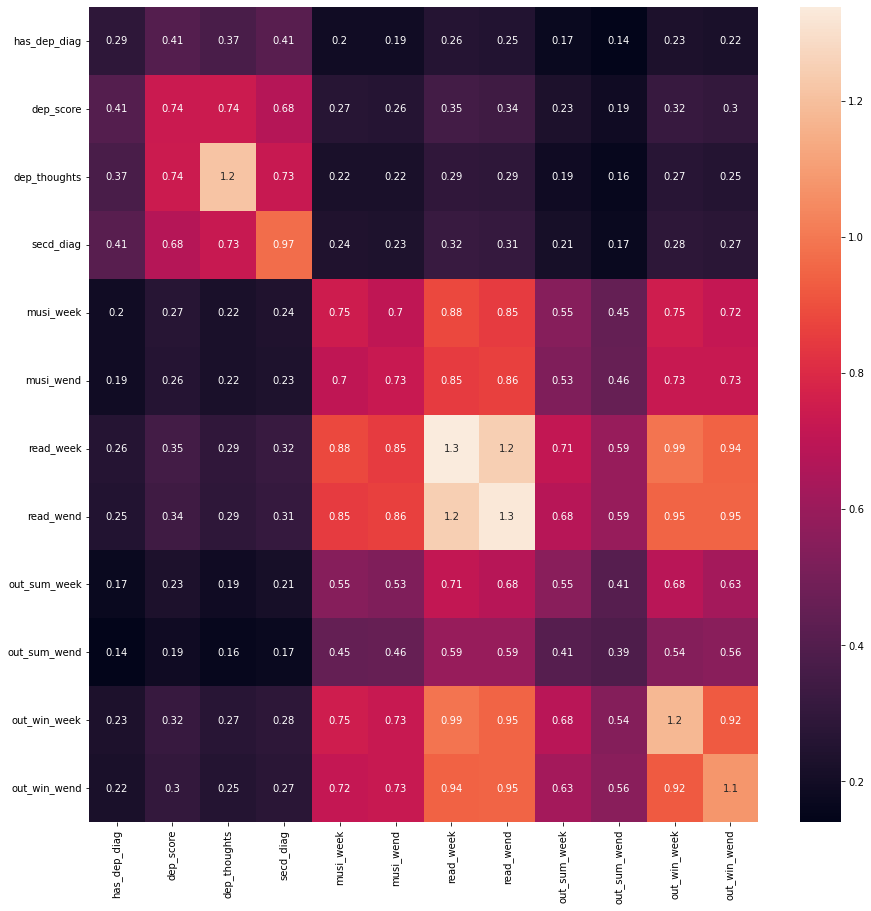

In [9]:
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(cov_matrix, annot=True)

<AxesSubplot:>

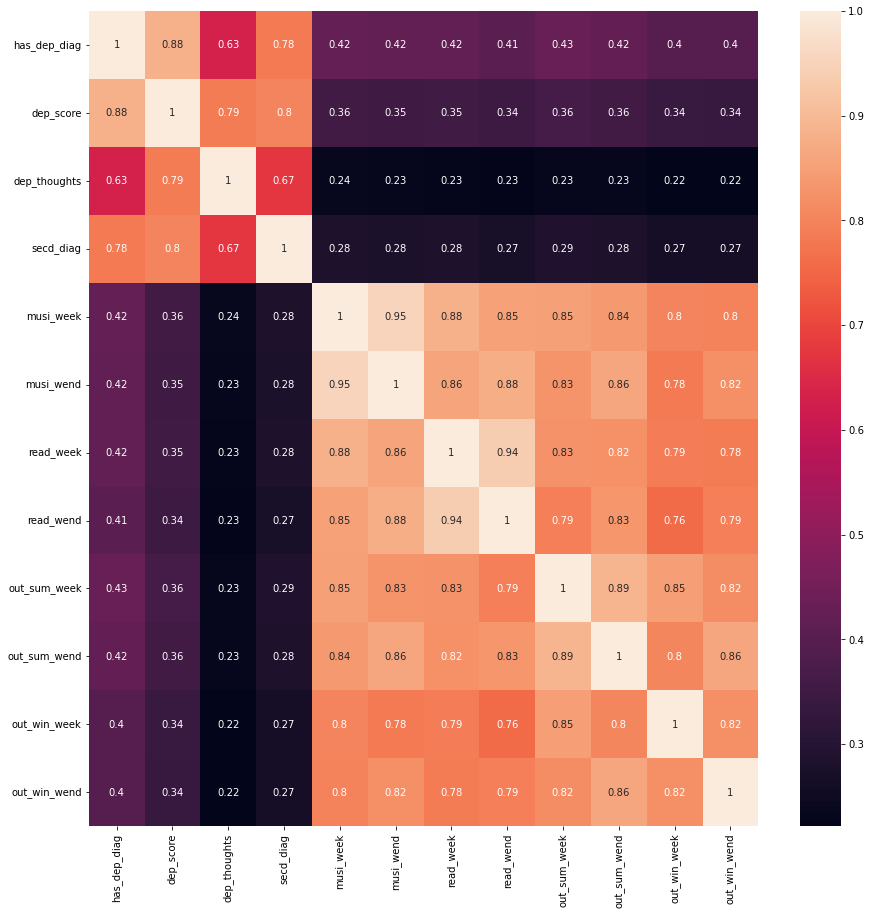

In [10]:
# Correlation matrix
corr_matrix = df.corr()#method='spearman')
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(corr_matrix, annot=True)

In [11]:
df

,has_dep_diag,dep_score,dep_thoughts,secd_diag,musi_week,musi_wend,read_week,read_wend,out_sum_week,out_sum_wend,out_win_week,out_win_wend
0,1,1,0,1,2,2,2,2,1,1,2,2
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,2,1,1,2,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
13729,0,0,0,0,0,0,0,0,0,0,0,0
13730,0,0,0,0,1,1,2,2,2,1,1,2
13731,0,0,0,0,2,2,3,3,1,1,2,2
13732,1,1,0,1,1,1,3,3,2,1,1,2


<AxesSubplot:>

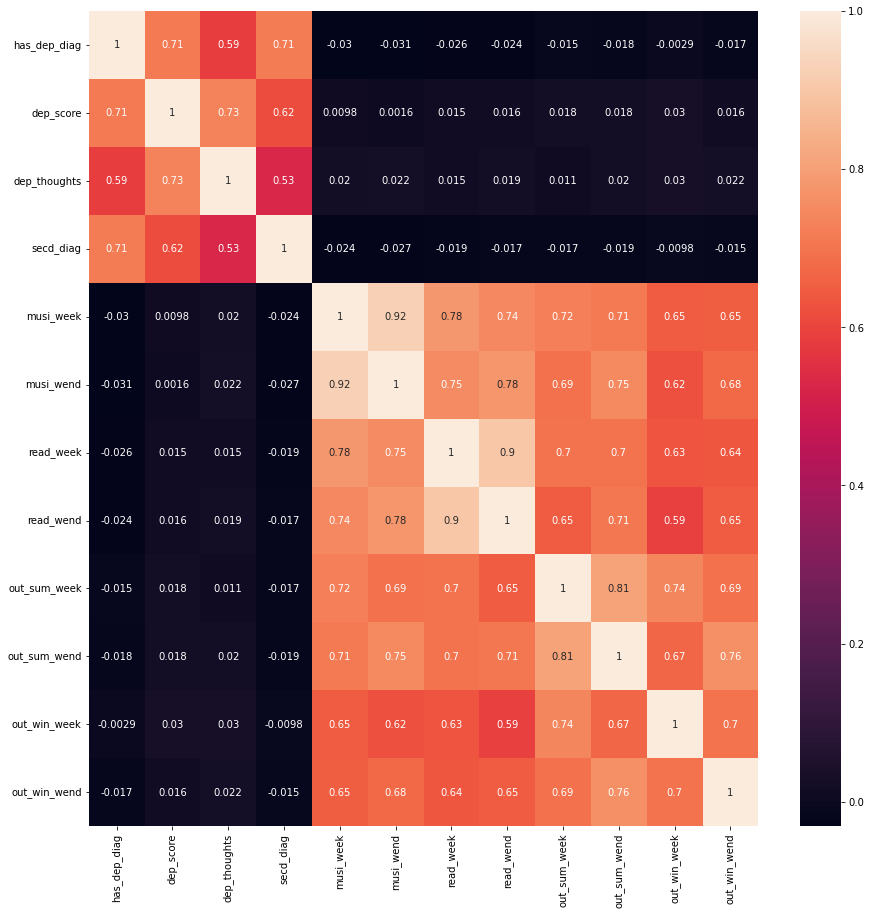

In [12]:
# Making a new dataframe where each row has at least one diagnoses column that is not a NaN.
# Checking to see if this makes a difference, to make the columns more correlated?
diag_cols = ['has_dep_diag',
             'dep_score',
             'dep_thoughts',
             'secd_diag']

df = raw_df.dropna(how="all", subset=diag_cols)
df = df[columns]
df = fill_nan_encode_categories(df)

corr_matrix = df.corr()#method='spearman')
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(corr_matrix, annot=True)

## PCA / UMAP Analysis

In [13]:
# removing any row that has NaN in dep_score
# screen time is correlated to weekend?
# reduce the number of columns?
df = raw_df.dropna(subset=['dep_score'])
df = df.astype('category')
df = df.apply(lambda x: x.cat.codes)

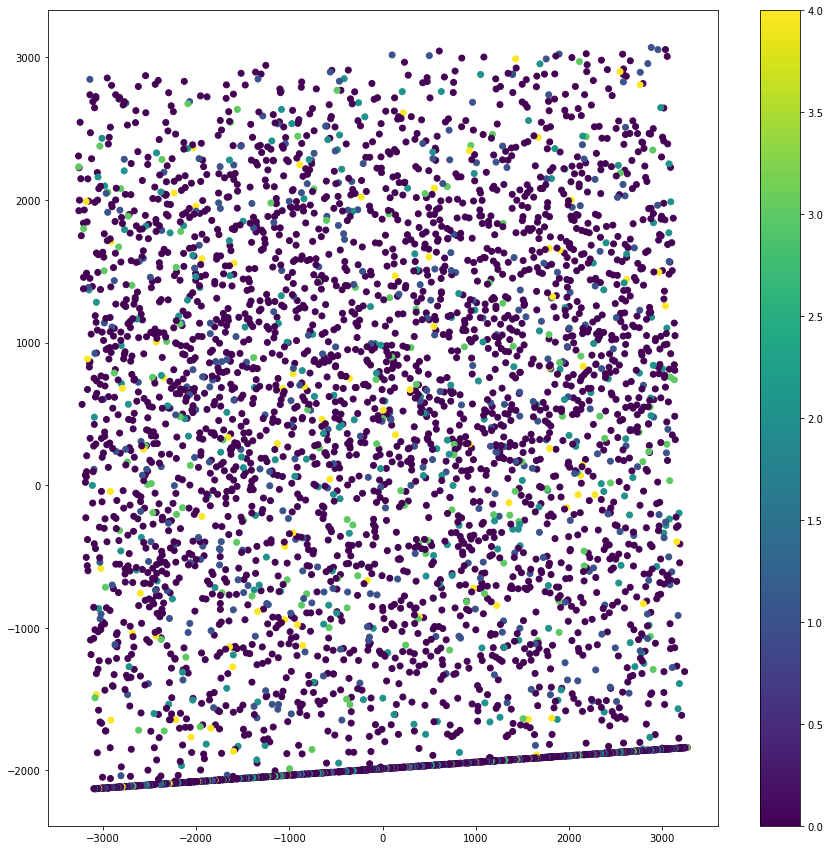

In [14]:
# PCA First

embedder = PCA()
embedder.fit(df)
embedding = embedder.transform(df)

plt.scatter(embedding[:,0],embedding[:,1], c=df['dep_score'])
plt.colorbar()

Well that is not helpful at all

Try UMAP?

UMAP(n_jobs=6, n_neighbors=500, verbose=True)
Thu Apr 14 19:50:30 2022 Construct fuzzy simplicial set
Thu Apr 14 19:50:30 2022 Finding Nearest Neighbors
Thu Apr 14 19:50:30 2022 Building RP forest with 8 trees
Thu Apr 14 19:50:30 2022 NN descent for 12 iterations


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Thu Apr 14 19:50:39 2022 Finished Nearest Neighbor Search
Thu Apr 14 19:50:41 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Apr 14 19:50:47 2022 Finished embedding


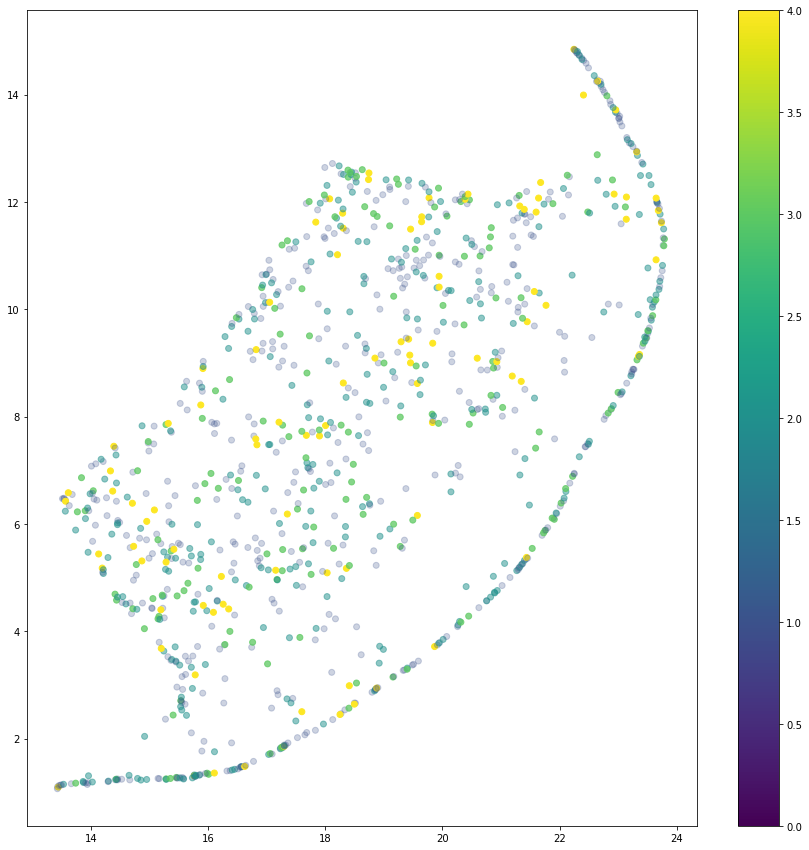

In [15]:
embedder = UMAP(n_neighbors=500,n_jobs=6,verbose=True)
embedder.fit(df)
embedding = embedder.transform(df)

plt.scatter(embedding[:,0],embedding[:,1], c=df['dep_score'],alpha=df['dep_score']/4) 
plt.colorbar()

That is a cool hat... don't think the data is relevent though. Colours are completely scattered throughout, no real clumps of data together either. Interesting line that makes up the rim of the hat though, wonder what that means

In [16]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)



In [17]:
# df = df[columns]
# df = df.head(1000)
# df.shape

In [18]:
# tsne_results = tsne.fit_transform(df)